In [1]:
import xarray as xr 
import glob 
import matplotlib.pyplot as plt
from scipy.signal import detrend

import numpy as np
import copy
import os 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle

import cartopy.crs as ccrs

from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

from eofs.xarray import Eof

import torch
from typing import Dict
from credit.physics_constants import RAD_EARTH, GRAVITY
from credit.physics_constants import RAD_EARTH, GRAVITY

import glob

from torch import nn
import numpy as np
import os

from credit.data import get_forward_data
from credit.transforms import load_transforms
from credit.physics_core import physics_pressure_level, physics_hybrid_sigma_level
from credit.physics_constants import (
    GRAVITY,
    RHO_WATER,
    LH_WATER,
    CP_DRY,
    CP_VAPOR,
)
from credit.postblock import GlobalEnergyFixer

import logging
import yaml
from credit.parser import credit_main_parser, predict_data_check
from dask.distributed import Client, get_client
import time

In [3]:
# Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
time.sleep(4)  # Sleeps for 1 second

No active client found.
Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/Grow/proxy/8787/status


## Residuals

In [25]:
FNS_nophys = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z_OG/pred*.nc'))
FNS_phys = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z/pred*.nc'))
DS_nophys = xr.open_mfdataset(FNS_nophys[:100])
DS_phys = xr.open_mfdataset(FNS_phys[:100])

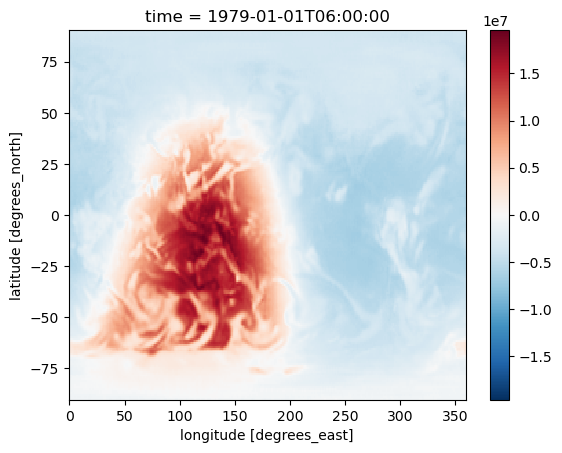

In [30]:
(DS_nophys['FLNT']+DS_nophys['FSNT']).isel(time=0).plot()
plt.show()

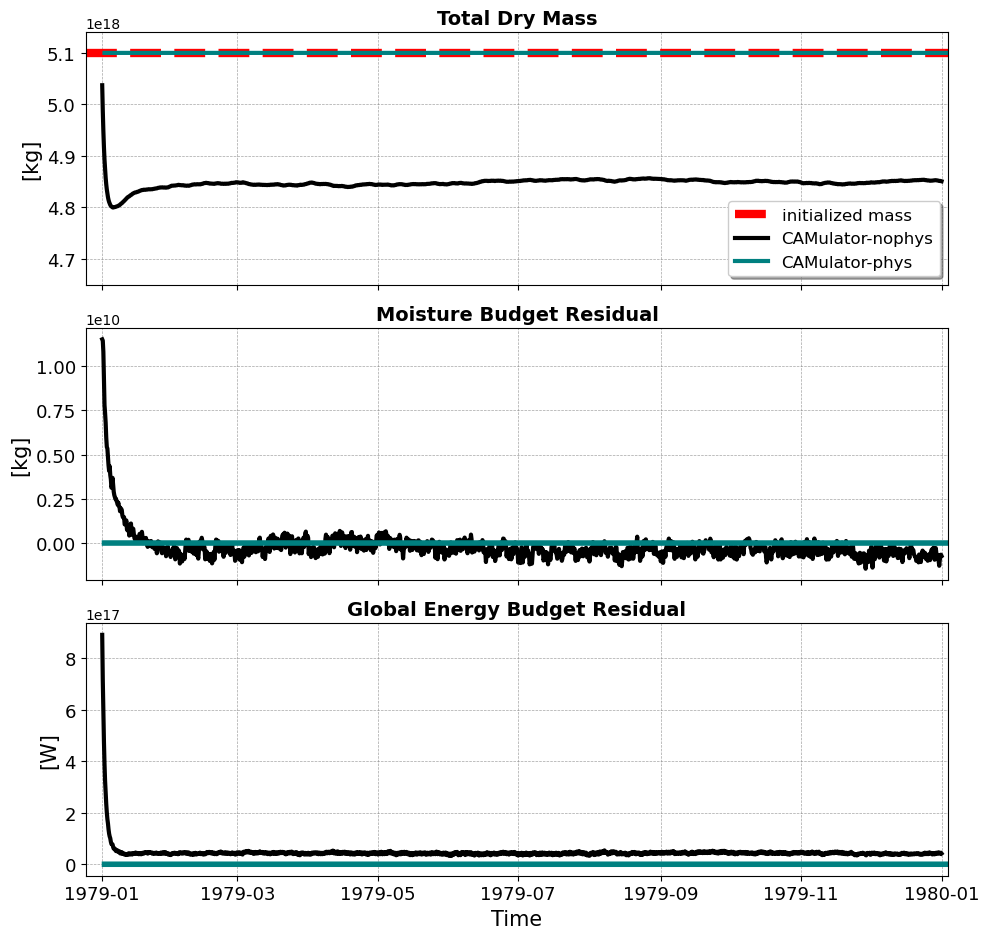

In [38]:
import matplotlib.pyplot as plt
import xarray as xr

# Load datasets
DS_nophys_res = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_1979-01-01T00Z_conserve_nopostblock_True_Save.nc')
DS_phys_res = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_1979-01-02T00Z_conserve_postblock_True_Save.nc')

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Plot Residual of Moisture Budget

# Plot Residual Dry Mass
axes[0].axhline(5100079038578984960, linestyle='--', label = 'initialized mass', linewidth=6, color='r')
axes[0].plot(DS_nophys_res['time'][:], 5100079038578984960 + DS_nophys_res['resid_mass'][:], label='CAMulator-nophys', color='k', linewidth=3)
axes[0].plot(DS_phys_res['time'][:], 5100079038578984960 + DS_phys_res['resid_mass'][:], label='CAMulator-phys', color='teal', linewidth=3)
axes[0].set_title("Total Dry Mass", fontsize=14, fontweight='bold')
axes[0].set_ylabel('[kg]', fontsize=15)
axes[0].legend(loc='lower right', fontsize=12, frameon=True, fancybox=True, shadow=True)
axes[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axes[0].set_ylim([4.65e18, 5.14e18])

axes[1].plot(DS_nophys_res['time'][:], DS_nophys_res['resid_water'][:], label='CAMulator-nophys', color='k', linewidth=3)
axes[1].plot(DS_phys_res['time'][:], DS_phys_res['resid_water'][:], label='CAMulator-phys', color='teal', linewidth=4)
axes[1].set_title("Moisture Budget Residual", fontsize=14, fontweight='bold')
axes[1].set_ylabel('[kg]', fontsize=15)
# axes[1,0].legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=True)
axes[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)


# Plot Global Energy Budget Residual
axes[2].plot(DS_nophys_res['time'][:], DS_nophys_res['resid_energy'][:], label='CAMulator-nophys', color='k', linewidth=3)
axes[2].plot(DS_phys_res['time'][:], DS_phys_res['resid_energy'][:], label='CAMulator-phys', color='teal', linewidth=4)
axes[2].set_title("Global Energy Budget Residual", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Time", fontsize=15)
axes[2].set_ylabel("[W]", fontsize=15)
# axes[2,0].legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=True)
axes[2].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust x-axis ticks for all subplots
axes[0].tick_params(axis='y', labelsize=13)
axes[1].tick_params(axis='y', labelsize=13)
axes[2].tick_params(axis='y', labelsize=13)
axes[0].tick_params(axis='x', labelsize=13)
axes[1].tick_params(axis='x', labelsize=13)
axes[2].tick_params(axis='x', labelsize=13)
plt.xticks(fontsize=13)
plt.xlim([3280,3655])
# Add a shared x-axis label

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Show the plot
plt.show()


## Total Water Column

In [46]:
print('...grab the model runs....')
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z_OG/1D/averaged_UVTQtotPSPRECTTREFHT*'))
print('... opening model run ...')
DSs = xr.open_mfdataset(FNS)

...grab the model runs....
... opening model run ...


## Open Files and Compute Path

loop number 0
loop number 1000
loop number 2000
loop number 3000
loop number 4000
loop number 5000
loop number 6000
loop number 7000
loop number 8000
loop number 9000
loop number 10000
doing 1979
doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
... resampling and loading ....


/glade/work/wchapman/conda-envs/credit-dk-casper/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 14.93 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


... resampled and loaded ....
loop number 0
loop number 1000
loop number 2000
loop number 3000
loop number 4000
loop number 5000
loop number 6000
loop number 7000
loop number 8000
loop number 9000
loop number 10000


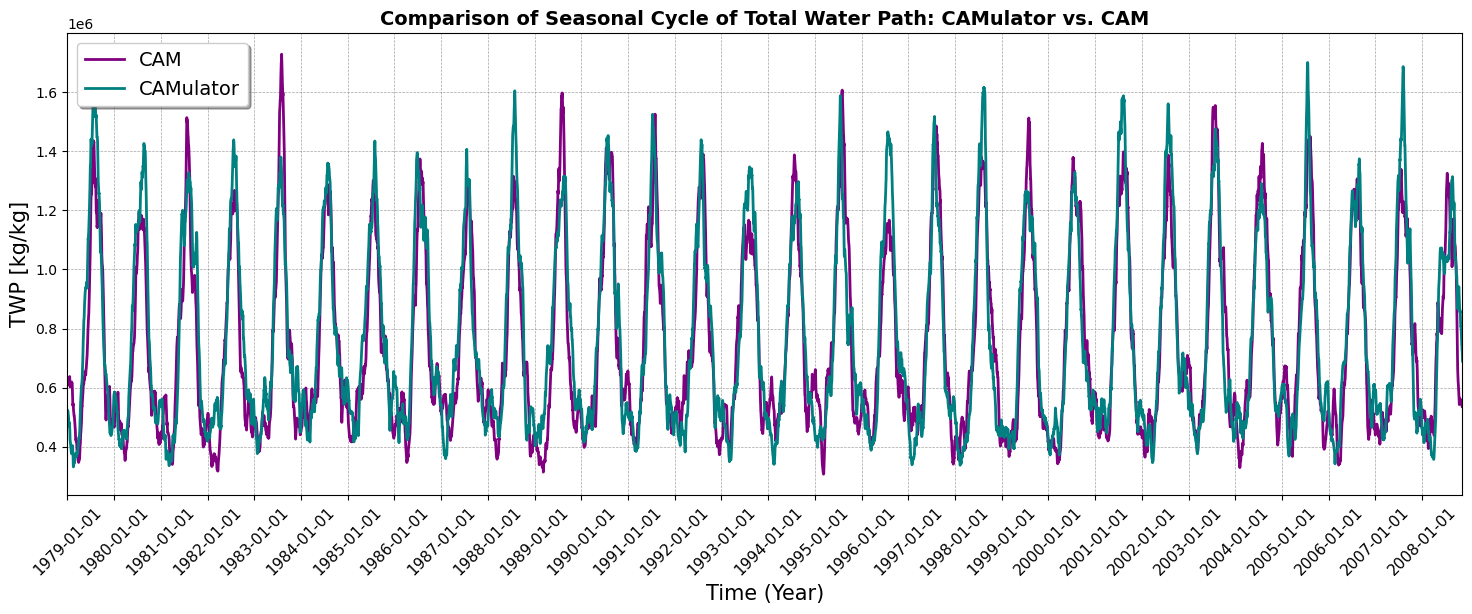

In [47]:
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)
DSml

phsl = physics_hybrid_sigma_level(lat=torch.tensor(DSml['lat2d'].values), 
                           lon = torch.tensor(DSml['lat2d'].values),
                           coef_a = torch.tensor(DSml['hyai'].values),
                           coef_b = torch.tensor(DSml['hybi'].values),midpoint=True)
bb = phsl.total_column_water(torch.tensor(np.expand_dims(DSs['Qtot'].isel(time=0).values,[0])),torch.tensor(np.expand_dims(DSs['PS'].isel(time=0).values,[0])))

tottote = []
for dd in range(10950):
    if (dd%1000) == 0:
        print(f'loop number {dd}')
    bb = phsl.total_column_water(torch.tensor(np.expand_dims(DSs['Qtot'].isel(time=dd).values,[0])),torch.tensor(np.expand_dims(DSs['PS'].isel(time=dd).values,[0])))
    Col_tot = phsl.weighted_sum(bb, axis=(-2, -1))
    tottote.append(np.array(Col_tot)[0])
# plt.plot(tottote)
# plt.show()

conc = []
for yryr in range(1979,2009):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['PS','Qtot']].resample(time='1D').mean().load()
print('... resampled and loaded ....')

DSzarr1_TP
tottot = []
for dd in range(10950):
    if (dd%1000) == 0:
        print(f'loop number {dd}')
    bb = phsl.total_column_water(torch.tensor(np.expand_dims(DSzarr1_TP['Qtot'].isel(time=dd).values,[0])),torch.tensor(np.expand_dims(DSzarr1_TP['PS'].isel(time=dd).values,[0])))
    Col_tot = phsl.weighted_sum(bb, axis=(-2, -1))
    tottot.append(np.array(Col_tot)[0])
# plt.plot(tottot)


def smooth_1d_array(data, window_size):
    """
    Apply a moving average smoothing filter to a 1D numpy array.

    Parameters:
    -----------
    data : np.ndarray
        The 1D array to smooth.
    window_size : int
        The size of the moving window (number of time steps).

    Returns:
    --------
    np.ndarray
        The smoothed array, with the same length as the input array.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be greater than or equal to the window size.")

    # Pad the array to handle edge effects
    padded_data = np.pad(data, pad_width=(window_size // 2,), mode='reflect')

    # Apply convolution for smoothing
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')

    return smoothed_data


# Create the plot
plt.figure(figsize=(18, 6))  # Larger figure for better visibility

# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in DSzarr1_TP['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(DSzarr1_TP['time'].values) if t.month == 1 and t.day == 1]

plt.plot(time_converted[:],smooth_1d_array(tottot,30)[:-1], label = 'CAM',color='purple', linewidth=2)
plt.plot(time_converted[:],smooth_1d_array(tottote,30)[:-1], label = 'CAMulator',color='teal', linewidth=2)
plt.legend()

# Customize x-axis ticks to show years
plt.xticks(
    year_ticks,
    [time_converted[i] for i in year_ticks],
    rotation=45,
    fontsize=11  # Smaller font size for clarity
)
# Adjust x-axis limits and labels
# plt.xlim([0, 5110])  # Limit the x-axis range
plt.xlabel("Time (Year)", fontsize=15)
plt.ylabel("TWP [kg/kg]", fontsize=15)
plt.xlim([0, 10900])  # Limit the x-axis range

# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
# Add a title
plt.title("Comparison of Seasonal Cycle of Total Water Path: CAMulator vs. CAM", fontsize=14, fontweight='bold')

# Add grid lines for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

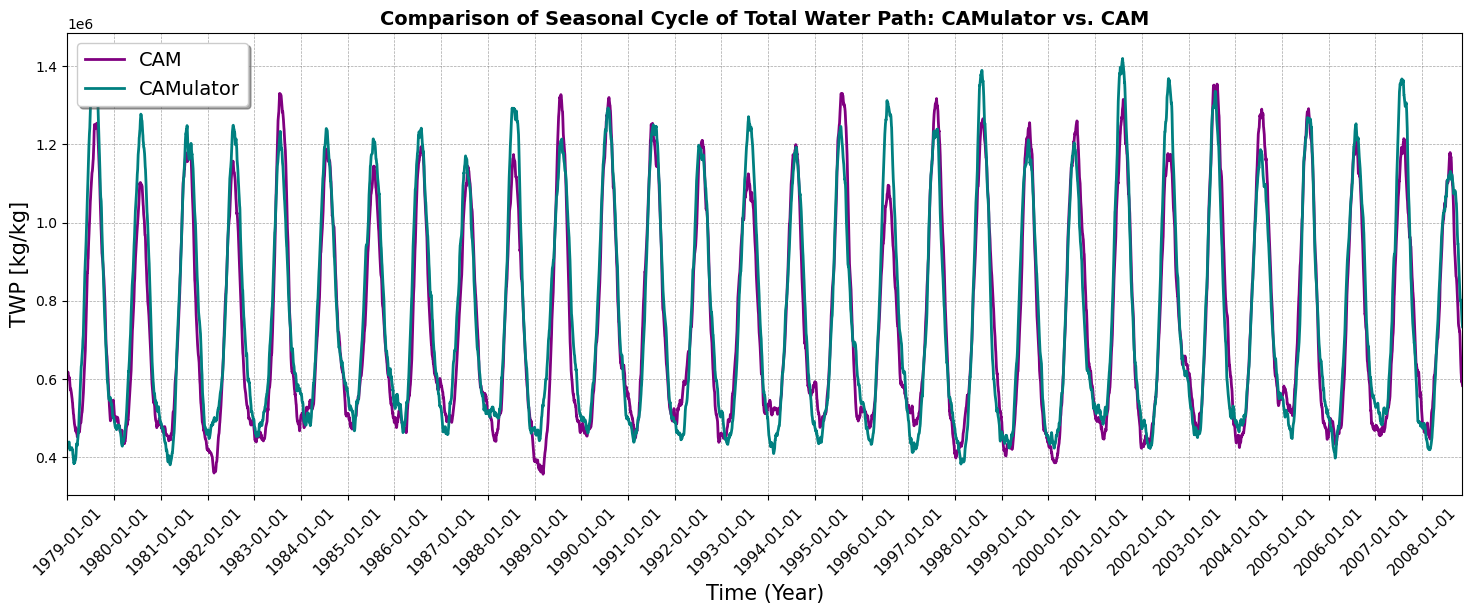

In [56]:
# Create the plot
import numpy as np

# Convert to NumPy arrays if they aren't already
tottot_array = np.array(tottot)
tottote_array = np.array(tottote)

# Save both arrays into a single .npz file
np.savez("./twp_data.npz", tottot=tottot_array, tottote=tottote_array)

# Load the .npz file
loaded_data = np.load("./twp_data.npz")

# Extract arrays and convert back to lists
tottot = loaded_data["tottot"].tolist()
tottote = loaded_data["tottote"].tolist()

plt.figure(figsize=(18, 6))  # Larger figure for better visibility

# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in DSzarr1_TP['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(DSzarr1_TP['time'].values) if t.month == 1 and t.day == 1]

plt.plot(time_converted[:],smooth_1d_array(tottot,90)[:-1], label = 'CAM',color='purple', linewidth=2)
plt.plot(time_converted[:],smooth_1d_array(tottote,90)[:-1], label = 'CAMulator',color='teal', linewidth=2)
plt.legend()

# Customize x-axis ticks to show years
plt.xticks(
    year_ticks,
    [time_converted[i] for i in year_ticks],
    rotation=45,
    fontsize=11  # Smaller font size for clarity
)
# Adjust x-axis limits and labels
# plt.xlim([0, 5110])  # Limit the x-axis range
plt.xlabel("Time (Year)", fontsize=15)
plt.ylabel("TWP [kg/kg]", fontsize=15)
plt.xlim([0, 10900])  # Limit the x-axis range

# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
# Add a title
plt.title("Comparison of Seasonal Cycle of Total Water Path: CAMulator vs. CAM", fontsize=14, fontweight='bold')

# Add grid lines for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

## Just make the figure:

In [4]:
%%time
conc = []
for yryr in range(1979,2009):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['PS','Qtot']].resample(time='1D').mean().load()
print('... resampled and loaded ....')


doing 1979
doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
... resampling and loading ....


/glade/work/wchapman/conda-envs/credit-dk-casper/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 14.93 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


... resampled and loaded ....
CPU times: user 2min 13s, sys: 43.7 s, total: 2min 56s
Wall time: 3min 15s


you need DSzarr1_TP from above


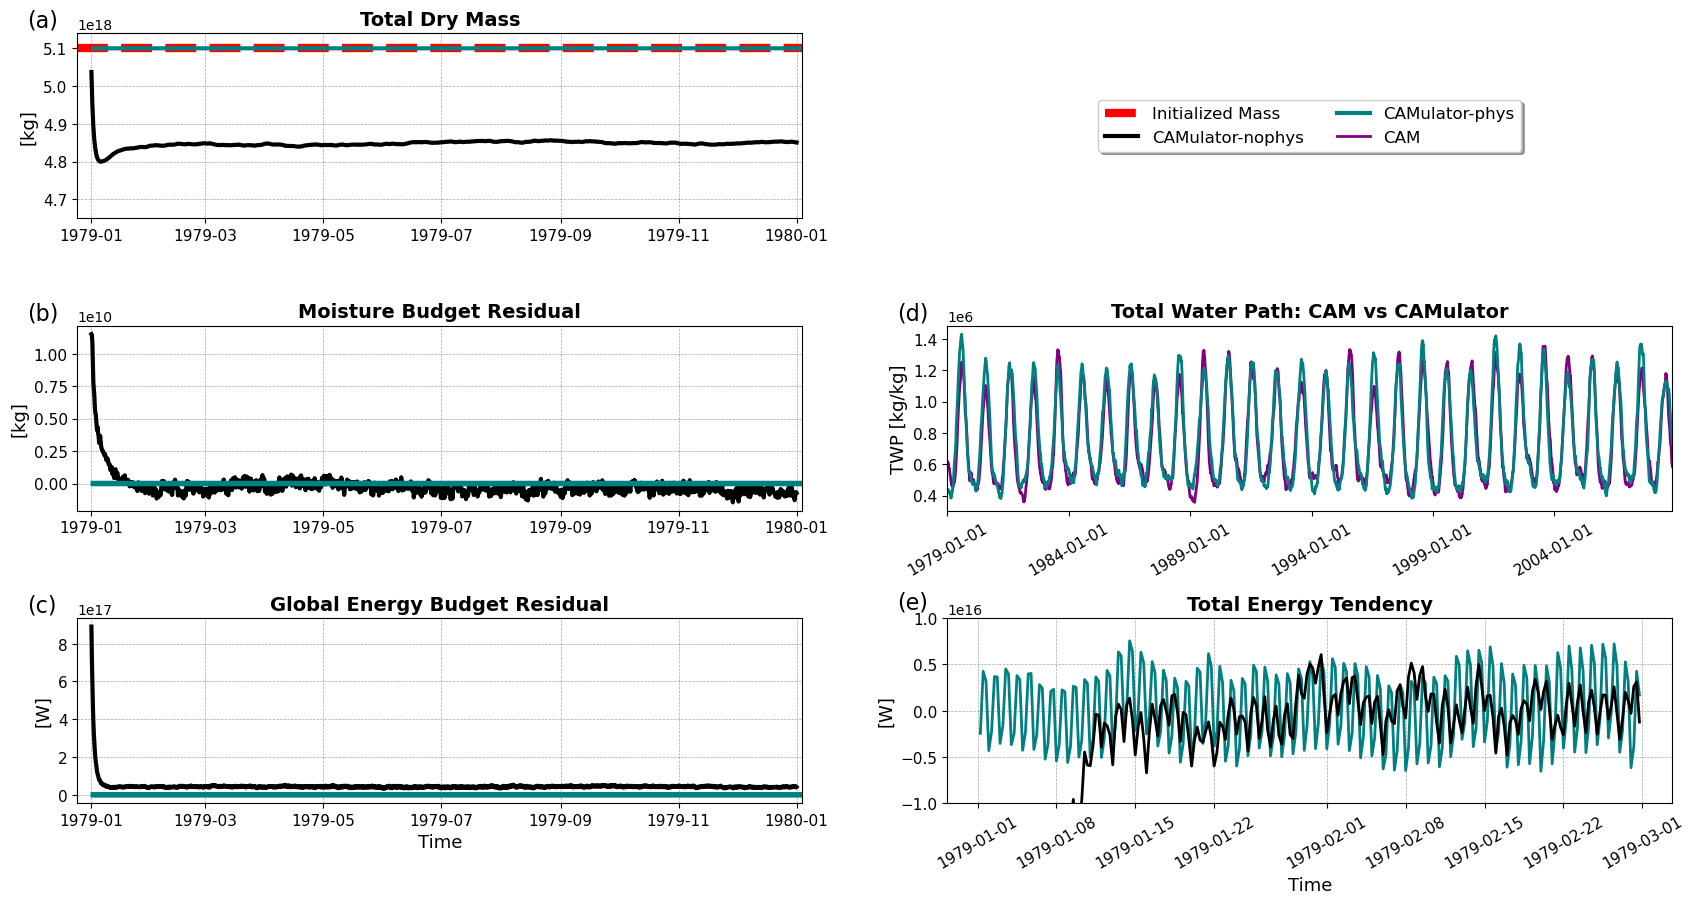

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

print('you need DSzarr1_TP from above')

def smooth_1d_array(data, window_size):
    """
    Apply a moving average smoothing filter to a 1D numpy array.

    Parameters:
    -----------
    data : np.ndarray
        The 1D array to smooth.
    window_size : int
        The size of the moving window (number of time steps).

    Returns:
    --------
    np.ndarray
        The smoothed array, with the same length as the input array.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be greater than or equal to the window size.")

    # Pad the array to handle edge effects
    padded_data = np.pad(data, pad_width=(window_size // 2,), mode='reflect')

    # Apply convolution for smoothing
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')

    return smoothed_data

# Load datasets
DS_nophys_res = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_1979-01-01T00Z_conserve_nopostblock_True.nc')
DS_phys_res = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_1979-01-02T00Z_conserve_postblock_True.nc')

DS_nophys_res_DT = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_energyincl_1979-01-01T00Z_noconserve_nopostblock_True.nc')
DS_phys_res_DT = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_energyincl_1979-01-01T00Z_conserve_nopostblock_True.nc')

# Load Total Water Path Data
loaded_data = np.load("./twp_data.npz")
tottot = loaded_data["tottot"].tolist()
tottote = loaded_data["tottote"].tolist()

# Convert cftime to datetime for Total Water Path plot
time_converted = [t.strftime('%Y-%m-%d') for t in DSzarr1_TP['time'].values]

year_ticks = [i for i, t in enumerate(DSzarr1_TP['time'].values) if t.month == 1 and t.day == 1]

# Create a 3-row, 2-column figure
fig, axes = plt.subplots(3, 2, figsize=(22, 10), gridspec_kw={'width_ratios': [1, 1]})

### --- Top Left Panel: Total Dry Mass --- ###
ax1 = axes[0, 0]
ax1.axhline(5100079038578984960, linestyle='--', label='Initialized Mass', linewidth=6, color='r')
ax1.plot(DS_nophys_res['time'], 5100079038578984960 + DS_nophys_res['resid_mass'], label='CAMulator-nophys', color='k', linewidth=3)
ax1.plot(DS_phys_res['time'], 5100079038578984960 + DS_phys_res['resid_mass'], label='CAMulator-phys', color='teal', linewidth=3)
ax1.set_title("Total Dry Mass", fontsize=14, fontweight='bold')
ax1.set_ylabel("[kg]", fontsize=13)
ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_ylim([4.65e18, 5.14e18])
ax1.set_xlim([3280,3655])
ax1.text(-0.07, 1.13, "(a)", transform=ax1.transAxes, fontsize=16, va='top', ha='left')
ax1.tick_params('x', labelsize=11)
ax1.tick_params('y', labelsize=11)


### --- Top Right Panel: Reserved for Legends --- ###
axes[0, 1].axis("off")  # Empty panel

### --- Middle Left Panel: Moisture Budget Residual --- ###
ax2 = axes[1, 0]
ax2.plot(DS_nophys_res['time'], DS_nophys_res['resid_water'], color='k', linewidth=3)
ax2.plot(DS_phys_res['time'], DS_phys_res['resid_water'], color='teal', linewidth=4)
ax2.set_title("Moisture Budget Residual", fontsize=14, fontweight='bold')
ax2.set_ylabel("[kg]", fontsize=13)
ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax2.set_xlim([3280,3655])
ax2.text(-0.07, 1.13, "(b)", transform=ax2.transAxes, fontsize=16, va='top', ha='left')
ax2.tick_params('x', labelsize=11)
ax2.tick_params('y', labelsize=11)

### --- Middle Right Panel: Total Water Path --- ###
ax3 = axes[1, 1]
# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in DSzarr1_TP['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(DSzarr1_TP['time'].values) if t.month == 1 and t.day == 1]

ax3.plot(time_converted, smooth_1d_array(tottot,90)[:-1], label='CAM', color='purple', linewidth=2)
ax3.plot(time_converted, smooth_1d_array(tottote,90)[:-1], color='teal', linewidth=2)
ax3.set_title("Total Water Path: CAM vs CAMulator", fontsize=14, fontweight='bold')
ax3.set_ylabel("TWP [kg/kg]", fontsize=13)
ax3.set_xticks(
    year_ticks,
    [time_converted[i] for i in year_ticks],
    rotation=30,
    fontsize=11  # Smaller font size for clarity
)
ax3.set_xlim([0, 10900])
ax3.text(-0.07, 1.13, "(d)", transform=ax3.transAxes, fontsize=16, va='top', ha='left')
ax3.set_xticks(year_ticks[::5])  # Display every 5th year tick
ax3.set_xticklabels([time_converted[i] for i in year_ticks[::5]], rotation=30, fontsize=11)
ax3.tick_params('y', labelsize=11)

### --- Bottom Left Panel: Global Energy Budget Residual --- ###
ax4 = axes[2, 0]
ax4.plot(DS_nophys_res['time'], DS_nophys_res['resid_energy'], color='k', linewidth=3)
ax4.plot(DS_phys_res['time'], DS_phys_res['resid_energy'], color='teal', linewidth=4)
ax4.set_title("Global Energy Budget Residual", fontsize=14, fontweight='bold')
ax4.set_xlabel("Time", fontsize=13)
ax4.set_ylabel("[W]", fontsize=13)
ax4.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax4.set_xlim([3280,3655])
ax4.text(-0.07, 1.13, "(c)", transform=ax4.transAxes, fontsize=16, va='top', ha='left')
ax4.tick_params('x', labelsize=11)
ax4.tick_params('y', labelsize=11)


### --- Bottom Right Panel: Total Energy Tendency --- ###
ax5 = axes[2, 1]
ax5.plot(DS_phys_res_DT['time'][:235], DS_phys_res_DT['energy_tend'][:235], color='teal', linewidth=2)
ax5.plot(DS_phys_res_DT['time'][:235], DS_nophys_res_DT['energy_tend'][:235], color='black', linewidth=2)

ax5.set_ylim([-10e15, 10e15])
ax5.set_title("Total Energy Tendency", fontsize=14, fontweight='bold')
ax5.set_xlabel("Time", fontsize=13)
ax5.set_ylabel("[W]", fontsize=13)
ax5.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax5.tick_params('x',rotation=30, labelsize=11)
ax5.text(-0.07, 1.15, "(e)", transform=ax5.transAxes, fontsize=16, va='top', ha='left')
ax5.tick_params('y', labelsize=11)

### --- Add Legends in the Top Right Panel --- ###
handles1, labels1 = ax1.get_legend_handles_labels()  # Dry Mass legend
handles2, labels2 = ax2.get_legend_handles_labels()  # Moisture Budget legend
handles3, labels3 = ax3.get_legend_handles_labels()  # Total Water Path legend
handles4, labels4 = ax4.get_legend_handles_labels()  # Energy Budget Residual legend
handles5, labels5 = ax5.get_legend_handles_labels()  # Total Energy Tendency legend

axes[0, 1].legend(handles1 + handles2 + handles3 + handles4 + handles5,
                  labels1 + labels2 + labels3 + labels4 + labels5,
                  loc='center', fontsize=12, frameon=True, fancybox=True, shadow=True, ncol=2, bbox_to_anchor=(0.5, 0.5))

# Adjust layout
fig.subplots_adjust(right=0.85, wspace=0.2, hspace=.58)

# Show the final figure
plt.show()


you need DSzarr1_TP from above


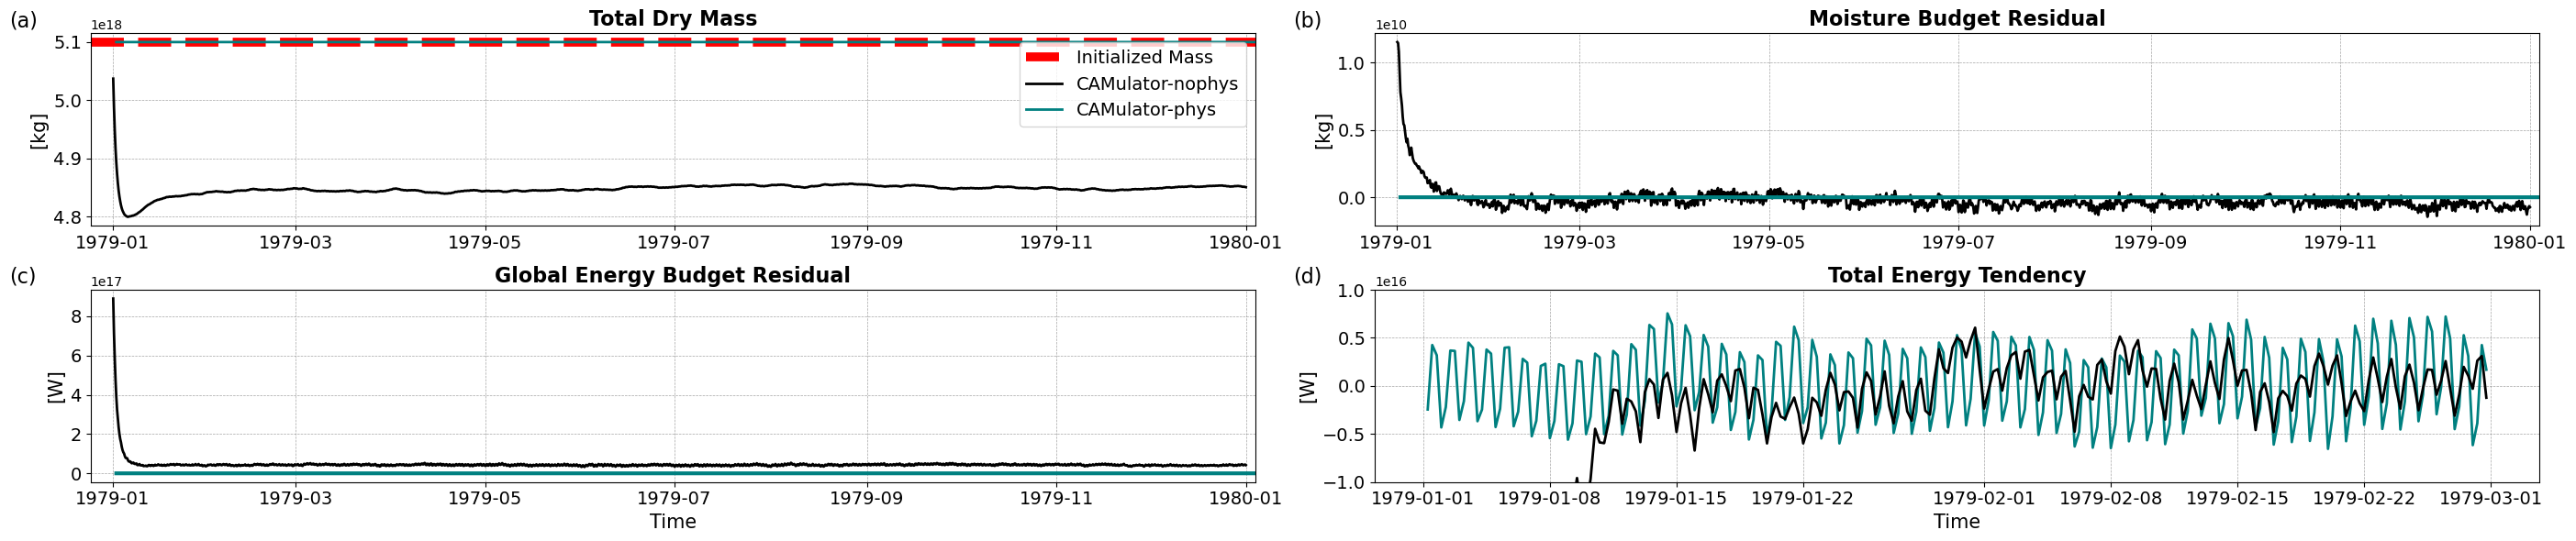

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

print('you need DSzarr1_TP from above')

def smooth_1d_array(data, window_size):
    """
    Apply a moving average smoothing filter to a 1D numpy array.
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be greater than or equal to the window size.")

    padded_data = np.pad(data, pad_width=(window_size // 2,), mode='reflect')
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')
    return smoothed_data

# Load datasets
DS_nophys_res = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_1979-01-01T00Z_conserve_nopostblock_True.nc')
DS_phys_res = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_1979-01-02T00Z_conserve_postblock_True.nc')
DS_nophys_res_DT = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_energyincl_1979-01-01T00Z_noconserve_nopostblock_True.nc')
DS_phys_res_DT = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_energyincl_1979-01-01T00Z_conserve_nopostblock_True.nc')

# Create a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(28, 6), gridspec_kw={'width_ratios': [1, 1]})

### --- Top Left Panel: Total Dry Mass --- ###
ax1 = axes[0, 0]
ax1.axhline(5100079038578984960, linestyle='--', label='Initialized Mass', linewidth=7, color='r')
ax1.plot(DS_nophys_res['time'], 5100079038578984960 + DS_nophys_res['resid_mass'], label='CAMulator-nophys', color='k', linewidth=2)
ax1.plot(DS_phys_res['time'], 5100079038578984960 + DS_phys_res['resid_mass'], label='CAMulator-phys', color='teal', linewidth=2)
ax1.set_title("Total Dry Mass", fontsize=16, fontweight='bold')
ax1.set_ylabel("[kg]", fontsize=15)
ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.set_xlim([3280,3655])
ax1.text(-0.07, 1.12, "(a)", transform=ax1.transAxes, fontsize=16, va='top', ha='left')
ax1.legend(fontsize=14)
ax1.tick_params('x', labelsize=14)
ax1.tick_params('y', labelsize=14)

### --- Top Right Panel: Moisture Budget Residual --- ###
ax2 = axes[0, 1]
ax2.plot(DS_nophys_res['time'], DS_nophys_res['resid_water'], color='k', linewidth=2)
ax2.plot(DS_phys_res['time'], DS_phys_res['resid_water'], color='teal', linewidth=3)
ax2.set_title("Moisture Budget Residual", fontsize=16, fontweight='bold')
ax2.set_ylabel("[kg]", fontsize=15)
ax2.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax2.set_xlim([3280,3655])
ax2.text(-0.07, 1.12, "(b)", transform=ax2.transAxes, fontsize=16, va='top', ha='left')
ax2.tick_params('x', labelsize=14)
ax2.tick_params('y', labelsize=14)

### --- Bottom Left Panel: Global Energy Budget Residual --- ###
ax3 = axes[1, 0]
ax3.plot(DS_nophys_res['time'], DS_nophys_res['resid_energy'], color='k', linewidth=2)
ax3.plot(DS_phys_res['time'], DS_phys_res['resid_energy'], color='teal', linewidth=3)
ax3.set_title("Global Energy Budget Residual", fontsize=16, fontweight='bold')
ax3.set_xlabel("Time", fontsize=15)
ax3.set_ylabel("[W]", fontsize=15)
ax3.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax3.set_xlim([3280,3655])
ax3.text(-0.07, 1.12, "(c)", transform=ax3.transAxes, fontsize=16, va='top', ha='left')
ax3.tick_params('x', labelsize=14)
ax3.tick_params('y', labelsize=14)

### --- Bottom Right Panel: Total Energy Tendency --- ###
ax4 = axes[1, 1]
ax4.plot(DS_phys_res_DT['time'][:235], DS_phys_res_DT['energy_tend'][:235], color='teal', linewidth=2)
ax4.plot(DS_phys_res_DT['time'][:235], DS_nophys_res_DT['energy_tend'][:235], color='black', linewidth=2)
ax4.set_ylim([-10e15, 10e15])
ax4.set_title("Total Energy Tendency", fontsize=16, fontweight='bold')
ax4.set_xlabel("Time", fontsize=15)
ax4.set_ylabel("[W]", fontsize=15)
ax4.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax4.text(-0.07, 1.12, "(d)", transform=ax4.transAxes, fontsize=16, va='top', ha='left')
ax4.tick_params('x', labelsize=14)
ax4.tick_params('y', labelsize=14)

# Adjust layout
fig.tight_layout()
fig.savefig('Conservation_Fig.png',dpi=250, bbox_inches='tight')
plt.show()


## Total System Energy

- get timestep-to-timestep

- Need to make this figure from the input shit. 

In [3]:
print('...grab the model runs....')
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00223_b/1979-01-01T00Z/pred_*'))
print('... opening model run ...')
# from dask.distributed import Client
# client = Client()
DSs = xr.open_mfdataset(FNS[:300]).load()

...grab the model runs....
... opening model run ...


In [5]:
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)
DSml
a=
phsl = physics_hybrid_sigma_level(lat=torch.tensor(DSml['lat2d'].values), 
                           lon = torch.tensor(DSml['lat2d'].values),
                           coef_a = torch.tensor(DSml['hyai'].values),
                           coef_b = torch.tensor(DSml['hybi'].values), midpoint=True)

In [146]:
config = '/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00223/model_multi_example-v2025.2.0.yml'
# asdf configuration from the YAML file
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

# Parse and preprocess the configuration for prediction
conf = credit_main_parser(conf, parse_training=False, parse_predict=True, print_summary=False)
post_conf = conf["model"]["post_conf"]
GEF = GlobalEnergyFixer(post_conf)

surf_net = post_conf["global_energy_fixer"]["surface_net_radiation_flux_name"]
TOA_net = post_conf["global_energy_fixer"]["TOA_net_radiation_flux_name"]
SE_flux = post_conf["global_energy_fixer"]["surface_energy_flux_name"]
SGP_name = post_conf["global_energy_fixer"]["surface_geopotential_name"]
SP_name = post_conf["global_energy_fixer"]["surface_pressure_name"]


st_tim = 0 
T_input = DSs['T'].isel(time=st_tim).values
q_input = DSs['Qtot'].isel(time=st_tim).values
U_input = DSs['U'].isel(time=st_tim).values
V_input = DSs['V'].isel(time=st_tim).values

# y_pred (batch, var, time, lat, lon)
# pick the first time-step, y_pred is expected to have the next step only
T_pred = DSs['T'].isel(time=st_tim+1).values
q_pred = DSs['Qtot'].isel(time=st_tim+1).values
U_pred = DSs['U'].isel(time=st_tim+1).values
V_pred = DSs['V'].isel(time=st_tim+1).values

TOA_solar_pred = DSs[TOA_net[0]].isel(time=st_tim+1).values
TOA_OLR_pred =  DSs[TOA_net[1]].isel(time=st_tim+1).values

surf_solar_pred = DSs[surf_net[0]].isel(time=st_tim+1).values
surf_LR_pred = DSs[surf_net[1]].isel(time=st_tim+1).values
surf_SH_pred = DSs[SE_flux[0]].isel(time=st_tim+1).values
surf_LH_pred =DSs[SE_flux[1]].isel(time=st_tim+1).values

sp_input = DSs[SP_name[0]].isel(time=st_tim).values
sp_pred = DSs[SP_name[0]].isel(time=st_tim+1).values

# heat capacity on constant pressure
CP_t0 = (1 - q_input) * CP_DRY + q_input * CP_VAPOR
CP_t1 = (1 - q_pred) * CP_DRY + q_pred * CP_VAPOR

# kinetic energy
ken_t0 = 0.5 * (U_input**2 + V_input**2)
ken_t1 = 0.5 * (U_pred**2 + V_pred**2)


GPH_surf = np.array(GEF.GPH_surf)
LH_WATER = 2.501e6  # J/kg
LH_ICE = 333700  # J/kg

print('dog')

# packing latent heat + potential energy + kinetic energy
E_qgk_t0 = LH_WATER * q_input + GPH_surf + ken_t0
E_qgk_t1 = LH_WATER * q_input + GPH_surf + ken_t1

 # TOA energy flux
R_T = (TOA_solar_pred + TOA_OLR_pred) / np.array(GEF.N_seconds)
R_T = torch.tensor(R_T)
R_T_sum =phsl.weighted_sum(R_T, axis=(-2, -1))
R_T_sum = np.array(R_T_sum)

# surface net energy flux
F_S = (
    surf_solar_pred + surf_LR_pred + surf_SH_pred + surf_LH_pred
) / np.array(GEF.N_seconds)
F_S = torch.tensor(F_S)
F_S_sum = phsl.weighted_sum(F_S, axis=(-2, -1))
F_S_sum = np.array(F_S_sum)
# ------------------------------------------------------------------------------ #
# thermal energy correction

# total energy per level
E_level_t0 = CP_t0 * T_input + E_qgk_t0
E_level_t1 = CP_t1 * T_pred + E_qgk_t1

TE_t0 = GEF.core_compute.integral(torch.tensor(E_level_t0).unsqueeze(0), torch.tensor(sp_input).unsqueeze(0)) / GRAVITY
TE_t1 = GEF.core_compute.integral(torch.tensor(E_level_t1).unsqueeze(0), torch.tensor(sp_pred).unsqueeze(0))/ GRAVITY

global_TE_t0 = GEF.core_compute.weighted_sum(TE_t0, axis=(-2, -1))
global_TE_t1 = GEF.core_compute.weighted_sum(TE_t1, axis=(-2, -1))

E_correct_ratio = (GEF.N_seconds * (R_T_sum - F_S_sum) + np.array(global_TE_t0)
        ) / np.array(global_TE_t1)

DOING just ENERGY taco
dog


## Energy Tendency

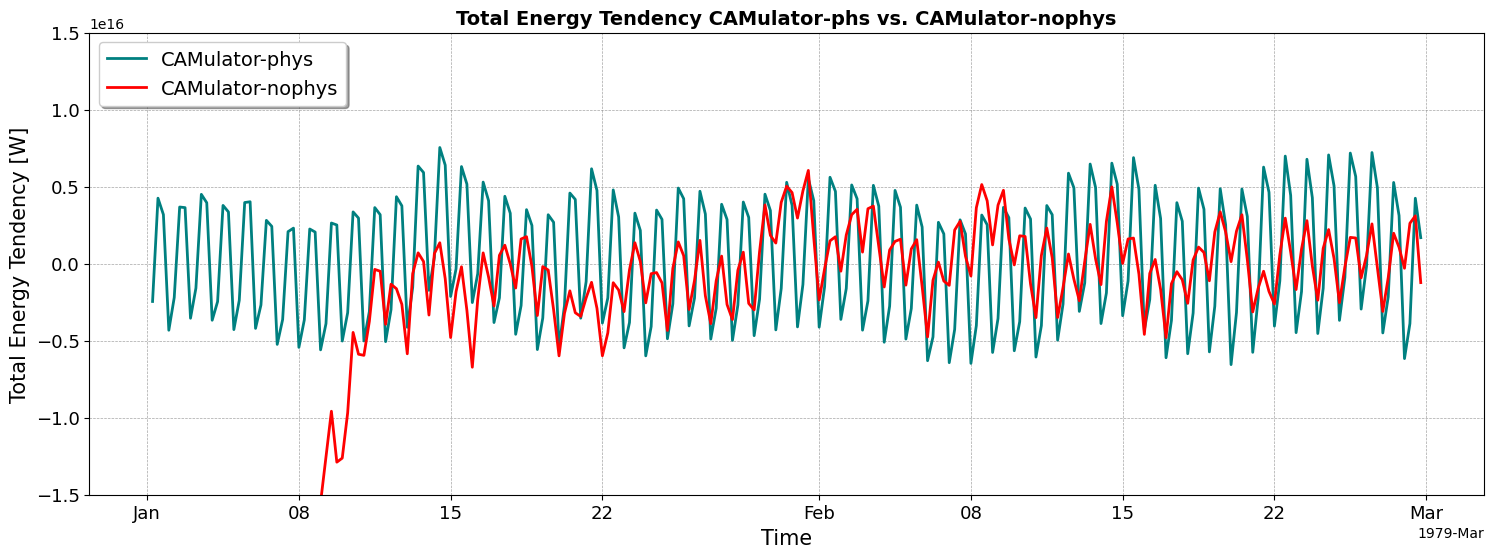

In [50]:
DS_nophys_res_DT = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_energyincl_1979-01-01T00Z_noconserve_nopostblock_True.nc')
DS_phys_res_DT = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT_runs/wxformer_1dg_cesm_data_nopost_bigbig_SSTforced_DryWaterEnergy/model_00191_nb/model_00240//residuals_energyincl_1979-01-01T00Z_conserve_nopostblock_True.nc')


# DS_nophys_res['energy_tend'].plot()
# Create the plot
plt.figure(figsize=(18, 6))  # Larger figure for better visibility

DS_phys_res_DT['energy_tend'][:235].plot(label = 'CAMulator-phys',color='teal', linewidth=2)
DS_nophys_res_DT['energy_tend'][:235].plot(label = 'CAMulator-nophys',color='red', linewidth=2)
plt.ylim([-15e15,15e15])

# Adjust x-axis limits and labels
# plt.xlim([0, 5110])  # Limit the x-axis range
plt.xlabel("Time", fontsize=15)
plt.ylabel("Total Energy Tendency [W]", fontsize=15)
# plt.xlim([0, 10900])  # Limit the x-axis range

# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
# Add a title
plt.title("Total Energy Tendency CAMulator-phs vs. CAMulator-nophys", fontsize=14, fontweight='bold')

# Add grid lines for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)


# Customize x-axis ticks to show years
plt.xticks(fontsize=13) # Smaller font size for clarity)
plt.yticks(fontsize=13) # Smaller font size for clarity)
plt.show()

In [ ]:
''

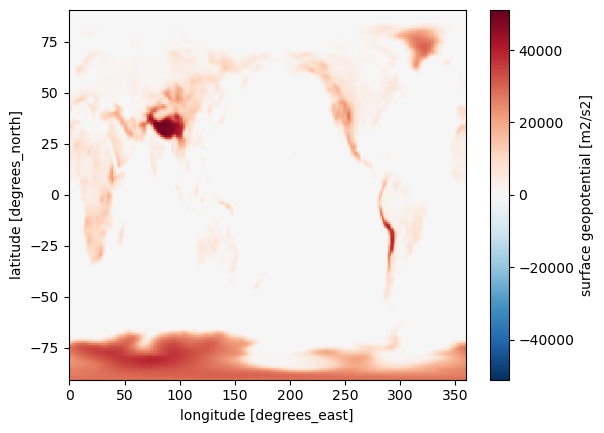

In [141]:
xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai_fixed.nc')['PHIS'].plot()

In [ ]:
'

## Dry Mass

## RESTOM 

In [3]:
# Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
time.sleep(4)  # Sleeps for 1 second

No active client found.
Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/bingo/proxy/8787/status


In [4]:
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z_OG/1D/averaged_SingleLevel_*'))
print('... opening model run ...')
DSs = xr.open_mfdataset(FNS)

FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-02T00Z/1D/averaged_SingleLevel_*'))
print('... opening model run ...')
DSs_phys = xr.open_mfdataset(FNS)

... opening model run ...
... opening model run ...


In [10]:
FSNT_1m = DSs['FSNT'].resample(time='1MS').mean().load()
print('done loading 1')
FLNT_1m = DSs['FLNT'].resample(time='1MS').mean().load()
print('done loading')

FSNT_1m_phys = DSs_phys['FSNT'].resample(time='1MS').mean().load()
print('done loading 1')
FLNT_1m_phys = DSs_phys['FLNT'].resample(time='1MS').mean().load()
print('done loading')


model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai.nc'
DSml = xr.open_dataset(model_level_file)
phsl = physics_hybrid_sigma_level(lat=torch.tensor(DSml['lat2d'].values), 
                           lon = torch.tensor(DSml['lat2d'].values),
                           coef_a = torch.tensor(DSml['hyai'].values),
                           coef_b = torch.tensor(DSml['hybi'].values),midpoint=True)

# FSNT_ws = phsl.weighted_sum(torch.tensor((FSNT_1m/21600).isel(time=slice(0,359)).values), axis=(-2, -1))
# FLNT_ws = phsl.weighted_sum(torch.tensor((FLNT_1m/-21600).isel(time=slice(0,359)).values), axis=(-2, -1))

done loading 1
done loading
done loading 1
done loading


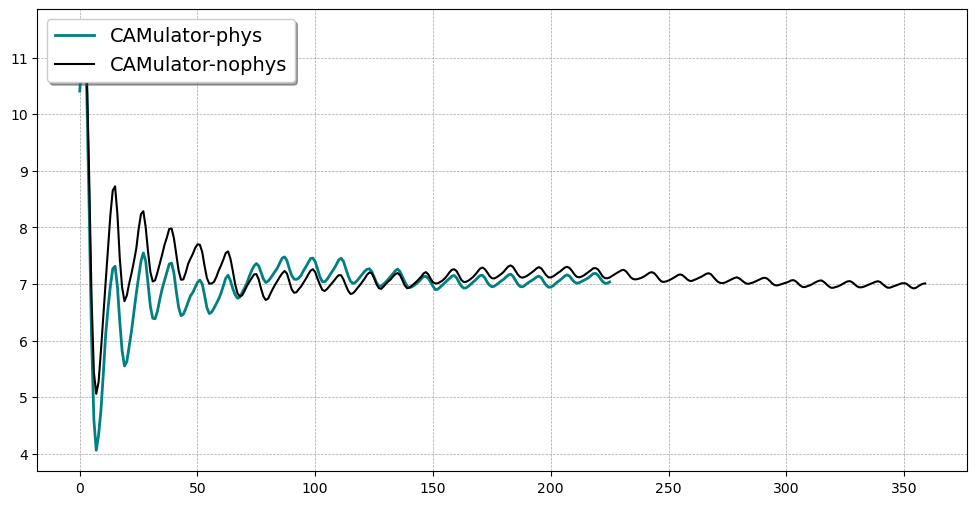

In [20]:
w = np.cos(np.radians(DSs['FSNT'].latitude))
FSNTts =(FSNT_1m/21600).weighted(w).mean(dim=("latitude","longitude"))
FLNTts =(FLNT_1m/-21600).weighted(w).mean(dim=("latitude","longitude"))

FSNTts_phys =(FSNT_1m_phys/21600).weighted(w).mean(dim=("latitude","longitude"))
FLNTts_phys =(FLNT_1m_phys/-21600).weighted(w).mean(dim=("latitude","longitude"))


plt.figure(figsize=(12, 6))  # Larger figure for better visibility

pulate = (FSNTts-FLNTts).rolling(time=350, min_periods=1).mean()
pulate_phys = (FSNTts_phys-FLNTts_phys).rolling(time=226, min_periods=1).mean()

plt.plot(pulate_phys, color='teal',linewidth=2, label='CAMulator-phys')
plt.plot(pulate, color='k', label='CAMulator-nophys')
# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
# Add grid lines for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [21]:
conc = []
for yryr in range(1979,2015):
    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    conc.append(DSdo_1)

print('... resampling and loading ....')
DSzarr1 = xr.concat(conc, dim='time')
DSzarr1_TP = DSzarr1[['FSNT','FLNT']].resample(time='1MS').mean().load()
print('... resampled and loaded ....')
FSNT_z_ws = phsl.weighted_sum(torch.tensor((DSzarr1_TP['FSNT']/21600).isel(time=slice(0,359)).values), axis=(-2, -1))
FLNT_z_ws = phsl.weighted_sum(torch.tensor((DSzarr1_TP['FLNT']/-21600).isel(time=slice(0,359)).values), axis=(-2, -1))

doing 1979
doing 1980
doing 1981
doing 1982
doing 1983
doing 1984
doing 1985
doing 1986
doing 1987
doing 1988
doing 1989
doing 1990
doing 1991
doing 1992
doing 1993
doing 1994
doing 1995
doing 1996
doing 1997
doing 1998
doing 1999
doing 2000
doing 2001
doing 2002
doing 2003
doing 2004
doing 2005
doing 2006
doing 2007
doing 2008
doing 2009
doing 2010
doing 2011
doing 2012
doing 2013
doing 2014
... resampling and loading ....
... resampled and loaded ....


## RESTOM

- add this as a validation meteric

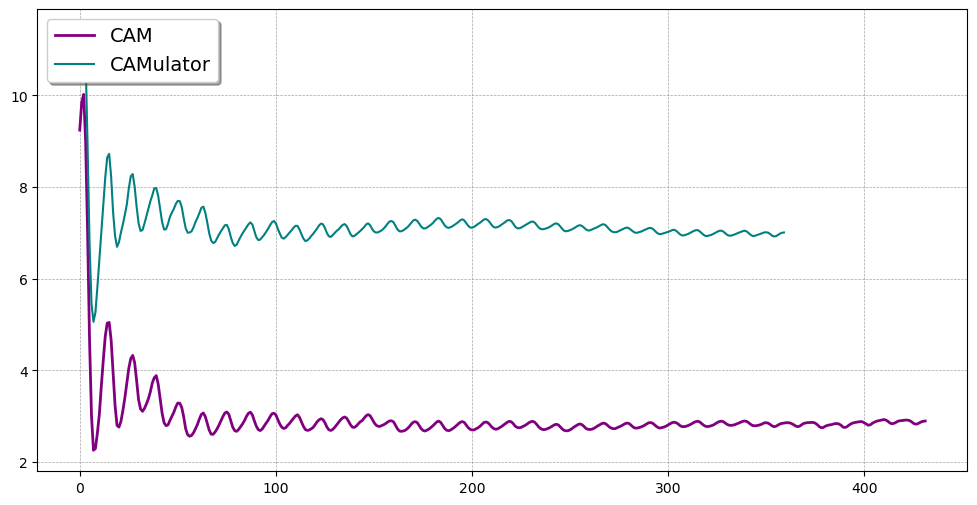

In [22]:
w = np.cos(np.radians(DSzarr1_TP['FSNT'].latitude))
FSNTts =(FSNT_1m/21600).weighted(w).mean(dim=("latitude","longitude"))
FLNTts =(FLNT_1m/-21600).weighted(w).mean(dim=("latitude","longitude"))

FSNTts_z = (DSzarr1_TP['FSNT']/21600).weighted(w).mean(dim=("latitude","longitude"))
FLNTts_z = (DSzarr1_TP['FLNT']/-21600).weighted(w).mean(dim=("latitude","longitude"))


plt.figure(figsize=(12, 6))  # Larger figure for better visibility

pcam = (FSNTts_z-FLNTts_z).rolling(time=350, min_periods=1).mean()
pulate = (FSNTts-FLNTts).rolling(time=350, min_periods=1).mean()

plt.plot(pcam, color='purple',linewidth=2, label='CAM')
plt.plot(pulate, color='teal', label='CAMulator')
# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
# Add grid lines for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

In [ ]:
# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in DSzarr1_TP['time'].values]

In [ ]:
# Create the plot
plt.figure(figsize=(18, 6))  # Larger figure for better visibility

# Convert cftime to datetime
time_converted = [t.strftime('%Y-%m-%d') for t in DSzarr1_TP['time'].values]

# Extract indices for January 1 of each year
year_ticks = [i for i, t in enumerate(DSzarr1_TP['time'].values) if t.month == 1 and t.day == 1]

plt.plot(time_converted[:],smooth_1d_array(tottot,30)[:-1], label = 'CAM',color='purple', linewidth=2)
plt.plot(time_converted[:],smooth_1d_array(tottote,30)[:-1], label = 'CAMulator',color='teal', linewidth=2)
plt.legend()

# Customize x-axis ticks to show years
plt.xticks(
    year_ticks,
    [time_converted[i] for i in year_ticks],
    rotation=45,
    fontsize=11  # Smaller font size for clarity
)
# Adjust x-axis limits and labels
# plt.xlim([0, 5110])  # Limit the x-axis range
plt.xlabel("Time (Year)", fontsize=15)
plt.ylabel("TWP [kg/kg]", fontsize=15)
plt.xlim([0, 10900])  # Limit the x-axis range

# Add legend with improved styling
plt.legend(
    loc='upper left',
    fontsize=14,
    frameon=True,
    fancybox=True,
    shadow=True
)
# Add a title
plt.title("Comparison of Seasonal Cycle of Total Water Path: CAMulator vs. CAM", fontsize=14, fontweight='bold')

# Add grid lines for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()